# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 19.67 MiB/s, done.
Resolving deltas: 100% (3/3), done.


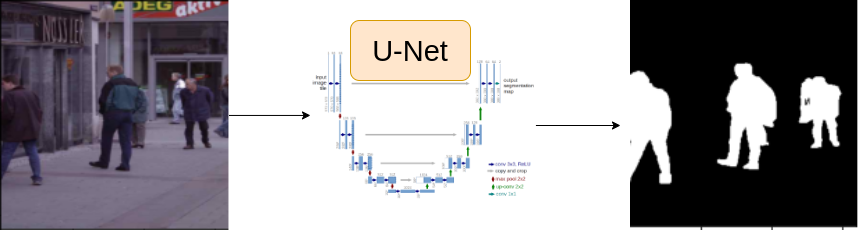

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [5]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [7]:
row = df.iloc[6]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

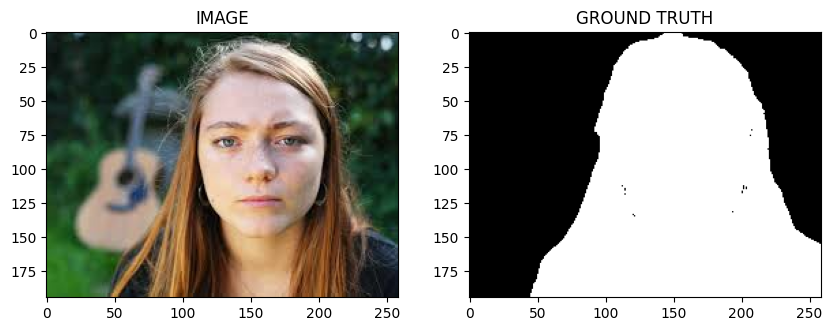

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [9]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [10]:
import albumentations as A

In [11]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5)
  ], is_check_shapes=False)

def get_valid_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE,IMAGE_SIZE)
  ], is_check_shapes=False)

# Task 4 : Create Custom Dataset

In [12]:
from torch.utils.data import Dataset

In [13]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):

    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):

    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis=-1)

    if self.augmentations:
      data = self.augmentations(image=image, mask=mask)
      image = data['image']
      mask = data['mask']

      image = np.transpose(image,(2,0,1)).astype(np.float32)
      mask = np.transpose(mask, (2,0,1)).astype(np.float32)

      image = torch.Tensor(image)/255.0
      mask = torch.round(torch.Tensor(mask)/255.0)

      return image, mask

In [14]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [15]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


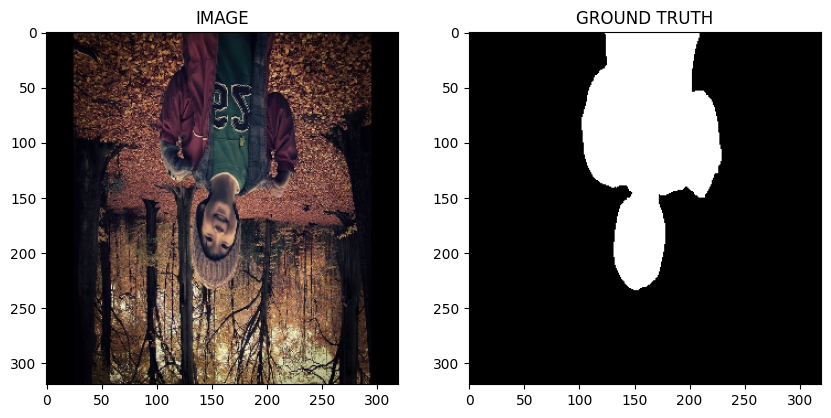

In [16]:
idx = 21

image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [17]:
from torch.utils.data import DataLoader

In [18]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle= True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [19]:
print(f"total no. of batches in trainloader : {len(trainloader)}")
print(f"total no. of batches in validloader: {len(validloader)}")

total no. of batches in trainloader : 15
total no. of batches in validloader: 4


In [20]:
for image, mask in trainloader:
  break
print(f"One batch image shape: {image.shape}")
print(f"One batch mask shape : {mask.shape}")

One batch image shape: torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [21]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [28]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
      encoder_name = ENCODER,
      encoder_weights= WEIGHTS,
      in_channels = 3,
      classes = 1,
      activation = None
  )

  def forward(self, images, masks = None):
    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1+loss2

    return logits

In [29]:
model = SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Task 7 : Create Train and Validation Function

In [34]:
def train_fn(data_loader, model, optimizer):
  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss/len(data_loader)

In [31]:
def eval_fn(data_loader, model):
  model.eval()
  total_loss = 0.0
  with torch.no_grad():
    for images, masks in tqdm(data_loader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()

  return total_loss/len(data_loader)

# Task 8 : Train Model

In [32]:
optimizer = torch.optim.Adam(model.parameters(), lr= LR)

In [35]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("SAVED THE MODEL")
    best_valid_loss = valid_loss

  print(f"Epoch:{i+1} Train_loss : {train_loss} valid_loss : {valid_loss}")

100%|██████████| 4/4 [00:01<00:00,  3.95it/s]


SAVED THE MODEL
Epoch:1 Train_loss : 0.7591687659422557 valid_loss : 1.4736274182796478


100%|██████████| 4/4 [00:00<00:00,  5.27it/s]


SAVED THE MODEL
Epoch:2 Train_loss : 0.37104668418566383 valid_loss : 0.4332508221268654


100%|██████████| 4/4 [00:00<00:00,  5.07it/s]


SAVED THE MODEL
Epoch:3 Train_loss : 0.31306699812412264 valid_loss : 0.316170372068882


100%|██████████| 4/4 [00:00<00:00,  5.19it/s]


Epoch:4 Train_loss : 0.3035760045051575 valid_loss : 0.3251228630542755


100%|██████████| 4/4 [00:00<00:00,  5.25it/s]


SAVED THE MODEL
Epoch:5 Train_loss : 0.27780462404092154 valid_loss : 0.22331930696964264


100%|██████████| 4/4 [00:00<00:00,  4.93it/s]


Epoch:6 Train_loss : 0.19934392372767132 valid_loss : 0.23344182595610619


100%|██████████| 4/4 [00:00<00:00,  5.26it/s]


Epoch:7 Train_loss : 0.19018203318119048 valid_loss : 0.23438555002212524


100%|██████████| 4/4 [00:01<00:00,  3.87it/s]


Epoch:8 Train_loss : 0.1591488927602768 valid_loss : 0.2962520271539688


100%|██████████| 4/4 [00:00<00:00,  5.12it/s]


SAVED THE MODEL
Epoch:9 Train_loss : 0.18098916759093603 valid_loss : 0.22136671468615532


100%|██████████| 4/4 [00:00<00:00,  5.15it/s]


Epoch:10 Train_loss : 0.183019224802653 valid_loss : 0.26631249859929085


100%|██████████| 4/4 [00:00<00:00,  5.15it/s]


Epoch:11 Train_loss : 0.15800941338141758 valid_loss : 0.2548058182001114


100%|██████████| 4/4 [00:00<00:00,  5.03it/s]


Epoch:12 Train_loss : 0.14327892661094666 valid_loss : 0.24331147596240044


100%|██████████| 4/4 [00:01<00:00,  3.80it/s]


SAVED THE MODEL
Epoch:13 Train_loss : 0.130144140124321 valid_loss : 0.2129497230052948


100%|██████████| 4/4 [00:00<00:00,  5.14it/s]


Epoch:14 Train_loss : 0.1616336797674497 valid_loss : 0.2674206830561161


100%|██████████| 4/4 [00:00<00:00,  5.24it/s]


Epoch:15 Train_loss : 0.14820740967988968 valid_loss : 0.21943310275673866


100%|██████████| 4/4 [00:00<00:00,  5.10it/s]


Epoch:16 Train_loss : 0.12260543604691823 valid_loss : 0.2146693617105484


100%|██████████| 4/4 [00:00<00:00,  5.10it/s]


Epoch:17 Train_loss : 0.14842518667380014 valid_loss : 0.3125688061118126


100%|██████████| 4/4 [00:01<00:00,  3.99it/s]


Epoch:18 Train_loss : 0.17820669660965602 valid_loss : 0.26429350301623344


100%|██████████| 4/4 [00:00<00:00,  4.65it/s]


Epoch:19 Train_loss : 0.14665664235750833 valid_loss : 0.2285003513097763


100%|██████████| 4/4 [00:00<00:00,  5.21it/s]


SAVED THE MODEL
Epoch:20 Train_loss : 0.12585688630739847 valid_loss : 0.16951937973499298


100%|██████████| 4/4 [00:01<00:00,  3.72it/s]


Epoch:21 Train_loss : 0.13710764348506926 valid_loss : 0.2348122037947178


100%|██████████| 4/4 [00:01<00:00,  3.95it/s]


Epoch:22 Train_loss : 0.14445955802996954 valid_loss : 0.19151046127080917


100%|██████████| 4/4 [00:00<00:00,  5.06it/s]


Epoch:23 Train_loss : 0.11788554986317952 valid_loss : 0.2520781010389328


100%|██████████| 4/4 [00:01<00:00,  2.00it/s]


Epoch:24 Train_loss : 0.149408454199632 valid_loss : 0.25441647320985794


100%|██████████| 4/4 [00:00<00:00,  5.14it/s]

Epoch:25 Train_loss : 0.09833953976631164 valid_loss : 0.22554024681448936


# Task 9 : Inference

In [36]:
idx = 20

model.load_state_dict(torch.load("/content/best_model.pt"))
image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

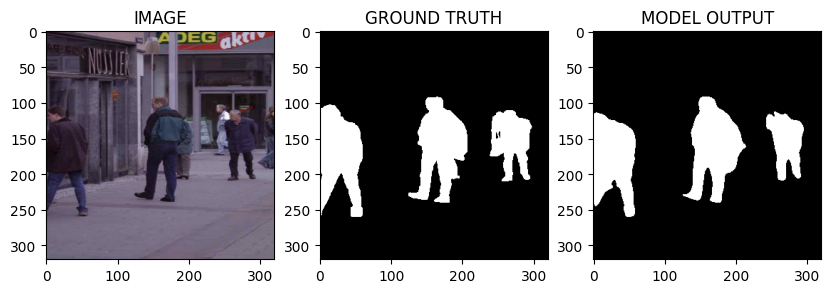

In [38]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))